In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
from scipy import stats
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv('/kaggle/input/superstore-sales/Superstore.csv', encoding="latin1")

In [3]:
df = df.drop_duplicates()

# Крок 1: Аналіз категорійної структури

Визначимо всі унікальні категорії

In [4]:
unique_categories = df['Category'].unique()
print("Унікальні категорії:", unique_categories)

Унікальні категорії: ['Furniture' 'Office Supplies' 'Technology']


Визначимо всі підкатегорії в кожній категорії

In [5]:
subcategories_per_category = df.groupby('Category')['Sub-Category'].unique()
print("Підкатегорії в кожній категорії:\n", subcategories_per_category)

Підкатегорії в кожній категорії:
 Category
Furniture                   [Bookcases, Chairs, Tables, Furnishings]
Office Supplies    [Labels, Storage, Art, Binders, Appliances, Pa...
Technology                  [Phones, Accessories, Machines, Copiers]
Name: Sub-Category, dtype: object


Підрахунок кількості SKU в кожній категорії та підкатегорії

In [6]:
sku_counts = df.groupby(['Category', 'Sub-Category'])['Product ID'].nunique().reset_index()
sku_counts.rename(columns={'Product ID': 'SKU Count'}, inplace=True)
print(sku_counts)

           Category Sub-Category  SKU Count
0         Furniture    Bookcases         49
1         Furniture       Chairs         87
2         Furniture  Furnishings        182
3         Furniture       Tables         57
4   Office Supplies   Appliances         98
5   Office Supplies          Art        163
6   Office Supplies      Binders        210
7   Office Supplies    Envelopes         54
8   Office Supplies    Fasteners         43
9   Office Supplies       Labels         70
10  Office Supplies        Paper        276
11  Office Supplies      Storage        131
12  Office Supplies     Supplies         38
13       Technology  Accessories        144
14       Technology      Copiers         13
15       Technology     Machines         63
16       Technology       Phones        184


Визначимо внесок у загальні продажі

In [7]:
# Загальна кількість проданих одиниць
total_quantity = df['Quantity'].sum()

# Внесок категорій
category_contribution = (
    df.groupby('Category')['Quantity']
    .sum()
    .reset_index()
    .assign(Contribution_Percent=lambda x: 100 * x['Quantity'] / total_quantity)
)

# Внесок підкатегорій
subcategory_contribution = (
    df.groupby(['Category', 'Sub-Category'])['Quantity']
    .sum()
    .reset_index()
    .assign(Contribution_Percent=lambda x: 100 * x['Quantity'] / total_quantity)
)

print("Внесок категорій:\n", category_contribution)
print("\nВнесок підкатегорій:\n", subcategory_contribution)

Внесок категорій:
           Category  Quantity  Contribution_Percent
0        Furniture      8028             21.197159
1  Office Supplies     22906             60.481082
2       Technology      6939             18.321760

Внесок підкатегорій:
            Category Sub-Category  Quantity  Contribution_Percent
0         Furniture    Bookcases       868              2.291870
1         Furniture       Chairs      2356              6.220791
2         Furniture  Furnishings      3563              9.407758
3         Furniture       Tables      1241              3.276741
4   Office Supplies   Appliances      1729              4.565258
5   Office Supplies          Art      3000              7.921210
6   Office Supplies      Binders      5974             15.773770
7   Office Supplies    Envelopes       906              2.392206
8   Office Supplies    Fasteners       914              2.413329
9   Office Supplies       Labels      1400              3.696565
10  Office Supplies        Paper      5

# Крок 2: Аналіз історичних даних

In [8]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

Частка кожної категорії в загальних продажах за останні періоди

In [9]:
df['YearMonth'] = df['Order Date'].dt.to_period('M')

# Групування за місяцем і категорією
monthly_sales = df.groupby(['YearMonth', 'Category'])['Quantity'].sum().reset_index()

# Додати загальні продажі на місяць
monthly_total = monthly_sales.groupby('YearMonth')['Quantity'].transform('sum')
monthly_sales['Share'] = monthly_sales['Quantity'] / monthly_total

print(monthly_sales.tail())

    YearMonth         Category  Quantity     Share
139   2014-11  Office Supplies      1071  0.598658
140   2014-11       Technology       375  0.209614
141   2014-12        Furniture       415  0.232754
142   2014-12  Office Supplies      1088  0.610208
143   2014-12       Technology       280  0.157039


Частка кожної підкатегорії в її батьківській категорії

In [10]:
subcategory_sales = df.groupby(['Category', 'Sub-Category'])['Quantity'].sum().reset_index()

# Додати загальні продажі для кожної категорії
category_totals = subcategory_sales.groupby('Category')['Quantity'].transform('sum')
subcategory_sales['Share_in_Category'] = subcategory_sales['Quantity'] / category_totals

print(subcategory_sales)

           Category Sub-Category  Quantity  Share_in_Category
0         Furniture    Bookcases       868           0.108122
1         Furniture       Chairs      2356           0.293473
2         Furniture  Furnishings      3563           0.443822
3         Furniture       Tables      1241           0.154584
4   Office Supplies   Appliances      1729           0.075482
5   Office Supplies          Art      3000           0.130970
6   Office Supplies      Binders      5974           0.260805
7   Office Supplies    Envelopes       906           0.039553
8   Office Supplies    Fasteners       914           0.039902
9   Office Supplies       Labels      1400           0.061119
10  Office Supplies        Paper      5178           0.226054
11  Office Supplies      Storage      3158           0.137868
12  Office Supplies     Supplies       647           0.028246
13       Technology  Accessories      2976           0.428880
14       Technology      Copiers       234           0.033722
15      

In [11]:
sku_sales = df.groupby(['Category', 'Sub-Category', 'Product ID'])['Quantity'].sum().reset_index()

# Додати загальні продажі на підкатегорію
subcategory_totals = sku_sales.groupby(['Category', 'Sub-Category'])['Quantity'].transform('sum')
sku_sales['Share_in_Subcategory'] = sku_sales['Quantity'] / subcategory_totals

print(sku_sales)


        Category Sub-Category       Product ID  Quantity  Share_in_Subcategory
0      Furniture    Bookcases  FUR-BO-10000112         9              0.010369
1      Furniture    Bookcases  FUR-BO-10000330        10              0.011521
2      Furniture    Bookcases  FUR-BO-10000362        14              0.016129
3      Furniture    Bookcases  FUR-BO-10000468        21              0.024194
4      Furniture    Bookcases  FUR-BO-10000711        12              0.013825
...          ...          ...              ...       ...                   ...
1857  Technology       Phones  TEC-PH-10004912        11              0.003344
1858  Technology       Phones  TEC-PH-10004922        19              0.005777
1859  Technology       Phones  TEC-PH-10004924         8              0.002432
1860  Technology       Phones  TEC-PH-10004959         4              0.001216
1861  Technology       Phones  TEC-PH-10004977        32              0.009729

[1862 rows x 5 columns]


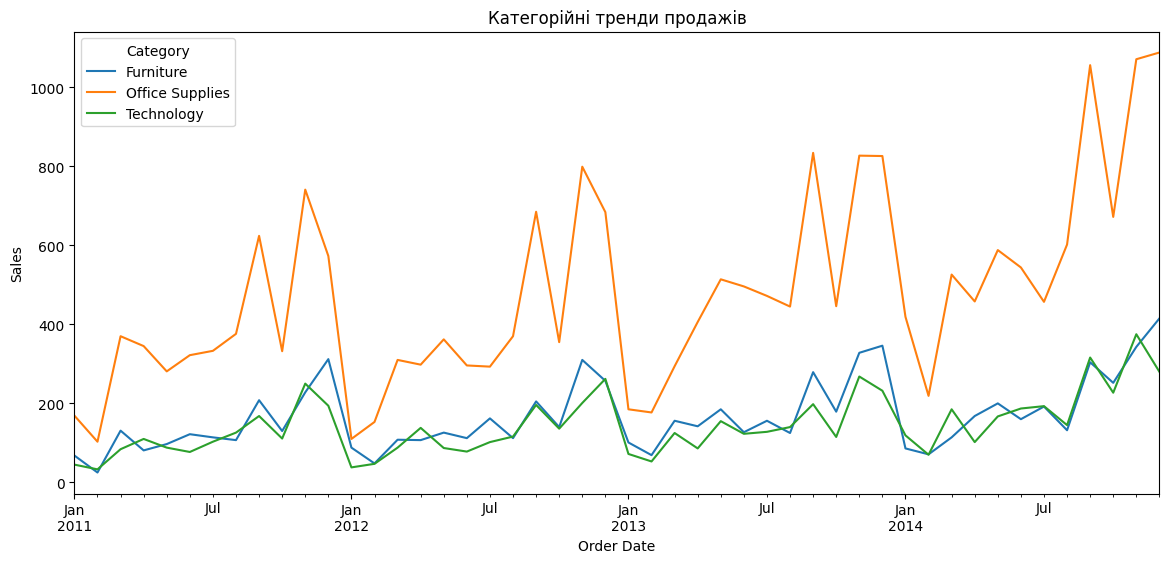

In [12]:
# Категорії: помісячні продажі
category_trends = df.groupby([df['Order Date'].dt.to_period('M'), 'Category'])['Quantity'].sum().unstack().fillna(0)

# Побудова графіку (за потреби)
import matplotlib.pyplot as plt
category_trends.plot(figsize=(14, 6), title='Категорійні тренди продажів')
plt.ylabel('Sales')
plt.show()


In [13]:
# Середній продаж по місяцях у розрізі року
df['Month'] = df['Order Date'].dt.month
seasonality = df.groupby(['Category', 'Month'])['Quantity'].mean().reset_index()

print(seasonality)


           Category  Month  Quantity
0         Furniture      1  4.287500
1         Furniture      2  3.276923
2         Furniture      3  3.770370
3         Furniture      4  3.635036
4         Furniture      5  3.973856
5         Furniture      6  3.721429
6         Furniture      7  3.714286
7         Furniture      8  3.777778
8         Furniture      9  3.531915
9         Furniture     10  3.789189
10        Furniture     11  3.813880
11        Furniture     12  3.993994
12  Office Supplies      1  3.789700
13  Office Supplies      2  3.725714
14  Office Supplies      3  3.658537
15  Office Supplies      4  3.666667
16  Office Supplies      5  3.777056
17  Office Supplies      6  3.759637
18  Office Supplies      7  3.792683
19  Office Supplies      8  3.984444
20  Office Supplies      9  3.689735
21  Office Supplies     10  3.800000
22  Office Supplies     11  3.993031
23  Office Supplies     12  3.815884
24       Technology      1  3.702703
25       Technology      2  3.327869
2

# Загальний прогноз

In [ ]:
import pandas as pd
data = {
    'Date': [
        '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
        '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
        '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'
    ],
    'Predicted_Quantity': [
        615.464966, 930.078796, 1367.803345, 1517.312378,
        1674.555176, 1665.634766, 1633.679932, 1712.018066,
        1753.078613, 1740.651367, 1768.306763, 1767.003540
    ]
}

sales_pred = pd.DataFrame(data)
sales_pred['Date'] = pd.to_datetime(sales_pred['Date'])

print(sales_pred)


         Date  Predicted_Quantity
0  2015-01-01          615.464966
1  2015-02-01          930.078796
2  2015-03-01         1367.803345
3  2015-04-01         1517.312378
4  2015-05-01         1674.555176
5  2015-06-01         1665.634766
6  2015-07-01         1633.679932
7  2015-08-01         1712.018066
8  2015-09-01         1753.078613
9  2015-10-01         1740.651367
10 2015-11-01         1768.306763
11 2015-12-01         1767.003540


# Крок 4: Розподіл на категорії

In [15]:
# Підрахунок історичних часток продажів по категоріях
category_shares = df.groupby('Category')['Quantity'].sum()
category_shares = category_shares / category_shares.sum()
print(category_shares)


Category
Furniture          0.211972
Office Supplies    0.604811
Technology         0.183218
Name: Quantity, dtype: float64


In [16]:
# Створимо новий датафрейм із категоріями, який будемо заповнювати
category_forecast = []

for _, row in sales_pred.iterrows():
    total = row['Predicted_Quantity']
    date = row['Date']
    for cat, share in category_shares.items():
        category_forecast.append({
            'Date': date,
            'Category': cat,
            'Forecast_Quantity': total * share
        })

category_forecast_df = pd.DataFrame(category_forecast)
print(category_forecast_df)


         Date         Category  Forecast_Quantity
0  2015-01-01        Furniture         130.461087
1  2015-01-01  Office Supplies         372.239868
2  2015-01-01       Technology         112.764011
3  2015-02-01        Furniture         197.150281
4  2015-02-01  Office Supplies         562.521715
5  2015-02-01       Technology         170.406801
6  2015-03-01        Furniture         289.935449
7  2015-03-01  Office Supplies         827.262256
8  2015-03-01       Technology         250.605640
9  2015-04-01        Furniture         321.627116
10 2015-04-01  Office Supplies         917.686936
11 2015-04-01       Technology         277.998326
12 2015-05-01        Furniture         354.958122
13 2015-05-01  Office Supplies        1012.789081
14 2015-05-01       Technology         306.807973
15 2015-06-01        Furniture         353.067248
16 2015-06-01  Office Supplies        1007.393920
17 2015-06-01       Technology         305.173597
18 2015-07-01        Furniture         346.293732


# Крок 6: Розподіл категорій на підкатегорії

In [17]:
# Групування і обчислення частки підкатегорії в межах своєї категорії
subcategory_shares = (
    df.groupby(['Category', 'Sub-Category'])['Quantity']
    .sum()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
)

print(subcategory_shares.head())


Category         Category         Sub-Category
Furniture        Furniture        Bookcases       0.108122
                                  Chairs          0.293473
                                  Furnishings     0.443822
                                  Tables          0.154584
Office Supplies  Office Supplies  Appliances      0.075482
Name: Quantity, dtype: float64


In [18]:
subcategory_forecast = []

for _, row in category_forecast_df.iterrows():
    date = row['Date']
    category = row['Category']
    cat_quantity = row['Forecast_Quantity']
    
    subcats = subcategory_shares.loc[category]
    
    for subcat, share in subcats.items():
        subcategory_forecast.append({
            'Date': date,
            'Category': category,
            'Sub-Category': subcat,
            'Forecast_Quantity': cat_quantity * share
        })

subcategory_forecast_df = pd.DataFrame(subcategory_forecast)
print(subcategory_forecast_df.head())


        Date         Category                   Sub-Category  \
0 2015-01-01        Furniture         (Furniture, Bookcases)   
1 2015-01-01        Furniture            (Furniture, Chairs)   
2 2015-01-01        Furniture       (Furniture, Furnishings)   
3 2015-01-01        Furniture            (Furniture, Tables)   
4 2015-01-01  Office Supplies  (Office Supplies, Appliances)   

   Forecast_Quantity  
0          14.105658  
1          38.286786  
2          57.901452  
3          20.167191  
4          28.097561  


# Крок 8: Сегментація SKU в межах підкатегорій (XYZ)

In [19]:

# Сума продажів за місяцями для кожного SKU
sku_monthly = df.groupby(['Sub-Category', 'Product ID', 'Month'])['Quantity'].sum().reset_index()


In [20]:
# Групування за SKU у кожній підкатегорії
sku_cv = (
    sku_monthly
    .groupby(['Sub-Category', 'Product ID'])['Quantity']
    .agg(['mean', 'std'])
    .reset_index()
)

sku_cv['cv'] = sku_cv['std'] / sku_cv['mean']


In [21]:
def classify_xyz(cv):
    if cv <= 0.5:
        return 'X'
    elif cv <= 1.0:
        return 'Y'
    else:
        return 'Z'

sku_cv['XYZ_Class'] = sku_cv['cv'].apply(classify_xyz)


In [22]:
xyz_result = sku_cv[['Sub-Category', 'Product ID', 'mean', 'std', 'cv', 'XYZ_Class']]
print(xyz_result.head())


  Sub-Category       Product ID      mean       std        cv XYZ_Class
0  Accessories  TEC-AC-10000023  6.000000  6.733003  1.122167         Z
1  Accessories  TEC-AC-10000057  4.750000  3.095696  0.651725         Y
2  Accessories  TEC-AC-10000109  7.250000  5.123475  0.706686         Y
3  Accessories  TEC-AC-10000158  3.857143  0.899735  0.233265         X
4  Accessories  TEC-AC-10000171  3.000000  0.816497  0.272166         X


# Розподіл за сегментами

In [ ]:
# Обчислення історичних часток SKU в межах кожної підкатегорії
sku_totals = df.groupby(['Sub-Category', 'Product ID'])['Quantity'].sum().reset_index()

# Розрахунок загальної кількості по підкатегорії
subcategory_totals = sku_totals.groupby('Sub-Category')['Quantity'].transform('sum')

# Розрахунок частки кожного SKU
sku_totals['Historical_Share'] = sku_totals['Quantity'] / subcategory_totals

# Залишаємо тільки потрібні стовпці
sku_shares = sku_totals[['Sub-Category', 'Product ID', 'Historical_Share']]

# Об'єднання з XYZ аналізом
sku_shares_xyz = sku_shares.merge(
    xyz_result[['Sub-Category', 'Product ID', 'XYZ_Class']], 
    on=['Sub-Category', 'Product ID'], 
    how='left'
)

print("SKU частки з XYZ класифікацією:")
print(sku_shares_xyz.head())

# Функція для коригування прогнозу на основі XYZ класу
def adjust_forecast_by_xyz(forecast_qty, xyz_class, base_share):
    if xyz_class == 'X':
        # Для стабільних товарів використовуємо історичну частку з мінімальними змінами
        adjustment_factor = 1.0
    elif xyz_class == 'Y':
        # Для помірно варіативних товарів трохи зменшуємо частку
        adjustment_factor = 0.95
    else:  # Z класс
        # Для високоваріативних товарів значно зменшуємо частку (консервативний підхід)
        adjustment_factor = 0.85
    
    return forecast_qty * base_share * adjustment_factor

# Створення фінального прогнозу по SKU
sku_forecast = []

for _, subcat_row in subcategory_forecast_df.iterrows():
    date = subcat_row['Date']
    category = subcat_row['Category']
    subcategory = subcat_row['Sub-Category']
    subcat_quantity = subcat_row['Forecast_Quantity']
    
    # Отримуємо всі SKU для цієї підкатегорії
    subcat_skus = sku_shares_xyz[sku_shares_xyz['Sub-Category'] == subcategory].copy()
    
    if len(subcat_skus) > 0:
        # Розраховуємо скориговані частки
        subcat_skus['Adjusted_Share'] = subcat_skus.apply(
            lambda row: adjust_forecast_by_xyz(1.0, row['XYZ_Class'], row['Historical_Share']), 
            axis=1
        )
        
        # Нормалізуємо частки, щоб їх сума дорівнювала 1
        total_adjusted_share = subcat_skus['Adjusted_Share'].sum()
        subcat_skus['Normalized_Share'] = subcat_skus['Adjusted_Share'] / total_adjusted_share
        
        # Розподіляємо прогноз
        for _, sku_row in subcat_skus.iterrows():
            sku_forecast.append({
                'Date': date,
                'Category': category,
                'Sub-Category': subcategory,
                'Product_ID': sku_row['Product ID'],
                'XYZ_Class': sku_row['XYZ_Class'],
                'Historical_Share': sku_row['Historical_Share'],
                'Adjusted_Share': sku_row['Normalized_Share'],
                'Forecast_Quantity': subcat_quantity * sku_row['Normalized_Share']
            })

sku_forecast_df = pd.DataFrame(sku_forecast)

print("\nПрогноз по SKU з урахуванням XYZ аналізу:")
print(sku_forecast_df.head(20))

# Аналіз розподілу прогнозу по XYZ класах
xyz_analysis = (
    sku_forecast_df.groupby(['Date', 'XYZ_Class'])['Forecast_Quantity']
    .sum()
    .reset_index()
)

xyz_monthly_totals = xyz_analysis.groupby('Date')['Forecast_Quantity'].transform('sum')
xyz_analysis['Share_by_XYZ'] = xyz_analysis['Forecast_Quantity'] / xyz_monthly_totals

print("\nРозподіл прогнозу по XYZ класах:")
print(xyz_analysis)

# Перевірка: загальна сума прогнозів SKU має дорівнювати початковому прогнозу
total_check = sku_forecast_df.groupby('Date')['Forecast_Quantity'].sum().reset_index()
total_check = total_check.merge(sales_pred, on='Date', how='left')
total_check['Difference'] = total_check['Forecast_Quantity'] - total_check['Predicted_Quantity']

print("\nПеревірка балансу прогнозів:")
print(total_check)

# Створення зведеної таблиці для аналізу
pivot_xyz = sku_forecast_df.pivot_table(
    index=['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class'],
    columns='Date',
    values='Forecast_Quantity',
    fill_value=0
).reset_index()

print("\nЗведена таблиця прогнозів по SKU:")
print(pivot_xyz.head())

# Статистика по XYZ класах
xyz_stats = (
    sku_forecast_df.groupby('XYZ_Class')
    .agg({
        'Product_ID': 'nunique',
        'Forecast_Quantity': ['sum', 'mean', 'std']
    })
    .round(2)
)

print("\nСтатистика по XYZ класах:")
print(xyz_stats)

SKU частки з XYZ класифікацією:
  Sub-Category       Product ID  Historical_Share XYZ_Class
0  Accessories  TEC-AC-10000023          0.008065         Z
1  Accessories  TEC-AC-10000057          0.006384         Y
2  Accessories  TEC-AC-10000109          0.009745         Y
3  Accessories  TEC-AC-10000158          0.009073         X
4  Accessories  TEC-AC-10000171          0.004032         X

Прогноз по SKU з урахуванням XYZ аналізу:
         Date   Category Sub-Category       Product_ID XYZ_Class  \
0  2015-01-01  Furniture    Bookcases  FUR-BO-10000112         Z   
1  2015-01-01  Furniture    Bookcases  FUR-BO-10000330         X   
2  2015-01-01  Furniture    Bookcases  FUR-BO-10000362         Y   
3  2015-01-01  Furniture    Bookcases  FUR-BO-10000468         Y   
4  2015-01-01  Furniture    Bookcases  FUR-BO-10000711         Y   
5  2015-01-01  Furniture    Bookcases  FUR-BO-10000780         Y   
6  2015-01-01  Furniture    Bookcases  FUR-BO-10001337         Y   
7  2015-01-01  Furnit

In [ ]:
# ===================== РОЗРАХУНОК МЕТРИК УПРАВЛІННЯ ЗАПАСАМИ =====================

# Створення датафрейму з параметрами для розрахунку метрик (легко редагувати)
inventory_params = pd.DataFrame({
    'XYZ_Class': ['X', 'Y', 'Z'],
    'Lead_Time_Days': [7, 10, 14],  # Час поставки в днях
    'Service_Level': [0.95, 0.90, 0.85],  # Рівень сервісу (95%, 90%, 85%)
    'Ordering_Cost': [50, 75, 100],  # Вартість оформлення замовлення
    'Holding_Cost_Rate': [0.20, 0.25, 0.30],  # Відсоток від вартості товару на рік
    'Unit_Cost': [25, 30, 35],  # Середня собівартість одиниці товару
    'Safety_Stock_Days': [7, 14, 21]  # Кількість днів для страхового запасу
})

print("\n=== ПАРАМЕТРИ ДЛЯ РОЗРАХУНКУ МЕТРИК УПРАВЛІННЯ ЗАПАСАМИ ===")
print(inventory_params)

# Функція для розрахунку z-score для заданого рівня сервісу
from scipy import stats

def get_z_score(service_level):
    return stats.norm.ppf(service_level)

# Додаємо z-score до параметрів
inventory_params['Z_Score'] = inventory_params['Service_Level'].apply(get_z_score)

# Розрахунок річного попиту для кожного SKU
annual_demand = sku_forecast_df.groupby(['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class'])['Forecast_Quantity'].sum().reset_index()
annual_demand.rename(columns={'Forecast_Quantity': 'Annual_Demand'}, inplace=True)

# Розрахунок середньоденного попиту та стандартного відхилення
daily_demand_stats = (
    sku_forecast_df.groupby(['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class'])['Forecast_Quantity']
    .agg(['mean', 'std'])
    .reset_index()
)
daily_demand_stats.columns = ['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class', 'Daily_Demand_Mean', 'Daily_Demand_Std']

# Заповнення NaN значень для стандартного відхилення (для випадків з одним значенням)
daily_demand_stats['Daily_Demand_Std'] = daily_demand_stats['Daily_Demand_Std'].fillna(
    daily_demand_stats['Daily_Demand_Mean'] * 0.1  # Припускаємо 10% від середнього
)

# Об'єднання всіх даних
inventory_data = annual_demand.merge(daily_demand_stats, on=['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class'])
inventory_data = inventory_data.merge(inventory_params, on='XYZ_Class')

# Розрахунок метрик управління запасами
def calculate_inventory_metrics(row):
    # Дані з рядка
    annual_demand = row['Annual_Demand']
    daily_demand_mean = row['Daily_Demand_Mean']
    daily_demand_std = row['Daily_Demand_Std']
    lead_time = row['Lead_Time_Days']
    ordering_cost = row['Ordering_Cost']
    holding_cost_rate = row['Holding_Cost_Rate']
    unit_cost = row['Unit_Cost']
    z_score = row['Z_Score']
    safety_days = row['Safety_Stock_Days']
    
    # 1. EOQ (Economic Order Quantity)
    holding_cost_per_unit = unit_cost * holding_cost_rate
    if holding_cost_per_unit > 0:
        eoq = (2 * annual_demand * ordering_cost / holding_cost_per_unit) ** 0.5
    else:
        eoq = 0
    
    # 2. Страховий запас (Safety Stock)
    # Метод 1: На основі рівня сервісу та варіації попиту
    if daily_demand_std > 0:
        safety_stock_service = z_score * daily_demand_std * (lead_time ** 0.5)
    else:
        safety_stock_service = 0
    
    # Метод 2: На основі днів покриття
    safety_stock_days = daily_demand_mean * safety_days
    
    # Використовуємо максимум з двох методів для більшої надійності
    safety_stock = max(safety_stock_service, safety_stock_days)
    
    # 3. ROP (Reorder Point)
    lead_time_demand = daily_demand_mean * lead_time
    rop = lead_time_demand + safety_stock
    
    # 4. Максимальний запас
    max_stock = rop + eoq
    
    # 5. Кількість замовлень на рік
    orders_per_year = annual_demand / eoq if eoq > 0 else 0
    
    # 6. Цикл замовлення (в днях)
    order_cycle_days = 365 / orders_per_year if orders_per_year > 0 else 0
    
    return pd.Series({
        'EOQ': round(eoq, 0),
        'Safety_Stock': round(safety_stock, 0),
        'ROP': round(rop, 0),
        'Max_Stock': round(max_stock, 0),
        'Lead_Time_Demand': round(lead_time_demand, 0),
        'Orders_Per_Year': round(orders_per_year, 1),
        'Order_Cycle_Days': round(order_cycle_days, 1),
        'Annual_Holding_Cost': round(safety_stock * unit_cost * holding_cost_rate, 2),
        'Annual_Ordering_Cost': round(orders_per_year * ordering_cost, 2)
    })

# Застосування розрахунків до всіх рядків
inventory_metrics = inventory_data.apply(calculate_inventory_metrics, axis=1)
final_results = pd.concat([inventory_data, inventory_metrics], axis=1)

# Вибір стовпців для фінального звіту
report_columns = [
    'Category', 'Sub-Category', 'Product_ID', 'XYZ_Class',
    'Annual_Demand', 'Daily_Demand_Mean', 'Daily_Demand_Std',
    'EOQ', 'Safety_Stock', 'ROP'
]

inventory_report = final_results[report_columns].copy()

# Сортування для зручності
inventory_report = inventory_report.sort_values(['Category', 'Sub-Category', 'Annual_Demand'], ascending=[True, True, False])

print("\n=== ЗВІТ ПО МЕТРИКАХ УПРАВЛІННЯ ЗАПАСАМИ ===")
print(f"Загальна кількість SKU: {len(inventory_report)}")
print("\nПерші 10 записів:")
print(inventory_report.head(10).to_string(index=False))

# Створення зведеного аналізу по XYZ класах
xyz_summary = inventory_report.groupby('XYZ_Class').agg({
    'Product_ID': 'count',
    'Annual_Demand': ['sum', 'mean'],
    'EOQ': 'mean',
    'Safety_Stock': 'mean',
    'ROP': 'mean',
    'Orders_Per_Year': 'mean',
    'Annual_Holding_Cost': 'sum',
    'Annual_Ordering_Cost': 'sum'
}).round(2)

xyz_summary.columns = ['SKU_Count', 'Total_Annual_Demand', 'Avg_Annual_Demand', 
                       'Avg_EOQ', 'Avg_Safety_Stock', 'Avg_ROP', 'Avg_Orders_Per_Year',
                       'Total_Holding_Cost', 'Total_Ordering_Cost']

print("\n=== ЗВЕДЕНИЙ АНАЛІЗ ПО XYZ КЛАСАХ ===")
print(xyz_summary)

# Топ-20 SKU за річним попитом
top_skus = inventory_report.nlargest(20, 'Annual_Demand')[
    ['Category', 'Sub-Category', 'Product_ID', 'XYZ_Class', 'Annual_Demand', 'EOQ', 'ROP', 'Safety_Stock']
]

print("\n=== ТОП-20 SKU ЗА РІЧНИМ ПОПИТОМ ===")
print(top_skus.to_string(index=False))

# Функція для експорту результатів
def export_inventory_results():
    """Експорт всіх результатів у CSV файли"""
    
    # 1. Основний звіт
    inventory_report.to_csv('inventory_management_report.csv', index=False, encoding='utf-8')
    print("\n✅ Основний звіт експортовано: inventory_management_report.csv")
    
    # 2. Параметри системи
    inventory_params.to_csv('inventory_parameters.csv', index=False, encoding='utf-8')
    print("✅ Параметри системи експортовано: inventory_parameters.csv")
    
    # 3. Зведений аналіз
    xyz_summary.to_csv('xyz_analysis_summary.csv', encoding='utf-8')
    print("✅ Зведений аналіз експортовано: xyz_analysis_summary.csv")
    
    # 4. Топ SKU
    top_skus.to_csv('top_20_skus.csv', index=False, encoding='utf-8')
    print("✅ Топ-20 SKU експортовано: top_20_skus.csv")
    
    # 5. Детальний прогноз
    sku_forecast_df.to_csv('detailed_sku_forecast.csv', index=False, encoding='utf-8')
    print("✅ Детальний прогноз експортовано: detailed_sku_forecast.csv")
    
    print("\n🎉 Всі файли успішно експортовано!")

# Функція для фільтрації результатів
def filter_results(category=None, xyz_class=None, min_demand=None, max_demand=None):
    """Фільтрація результатів за різними критеріями"""
    filtered_data = inventory_report.copy()
    
    if category:
        filtered_data = filtered_data[filtered_data['Category'] == category]
    if xyz_class:
        filtered_data = filtered_data[filtered_data['XYZ_Class'] == xyz_class]
    if min_demand:
        filtered_data = filtered_data[filtered_data['Annual_Demand'] >= min_demand]
    if max_demand:
        filtered_data = filtered_data[filtered_data['Annual_Demand'] <= max_demand]
    
    return filtered_data

print("\n=== ДОСТУПНІ ФУНКЦІЇ ===")
print("1. export_inventory_results() - експорт всіх результатів у CSV")
print("2. filter_results(category='Technology', xyz_class='X') - фільтрація результатів")
print("3. inventory_report - основна таблиця з результатами")
print("4. inventory_params - параметри для налаштування системи")

print("\nПриклад використання фільтрів:")
print("filter_results(category='Technology', min_demand=1000)")

# Автоматичний експорт (розкоментуйте при необхідності)
export_inventory_results()


=== ПАРАМЕТРИ ДЛЯ РОЗРАХУНКУ МЕТРИК УПРАВЛІННЯ ЗАПАСАМИ ===
  XYZ_Class  Lead_Time_Days  Service_Level  Ordering_Cost  Holding_Cost_Rate  \
0         X               7           0.95             50               0.20   
1         Y              10           0.90             75               0.25   
2         Z              14           0.85            100               0.30   

   Unit_Cost  Safety_Stock_Days  
0         25                  7  
1         30                 14  
2         35                 21  

=== ЗВІТ ПО МЕТРИКАХ УПРАВЛІННЯ ЗАПАСАМИ ===
Загальна кількість SKU: 1862

Перші 10 записів:
 Category Sub-Category      Product_ID XYZ_Class  Annual_Demand  Daily_Demand_Mean  Daily_Demand_Std  EOQ  Safety_Stock  ROP  Max_Stock  Lead_Time_Demand  Orders_Per_Year  Order_Cycle_Days  Lead_Time_Days  Service_Level  Unit_Cost  Annual_Holding_Cost  Annual_Ordering_Cost
Furniture    Bookcases FUR-BO-10002213         Z      17.894031           1.491169          0.365269 18.0         